Start this first
```bash
$ litex_server uart /dev/ttyUSB0 115200
```

In [2001]:
%pylab notebook
from litex.soc.tools.remote import RemoteClient
from struct import pack, unpack
import time

Populating the interactive namespace from numpy and matplotlib


In [1776]:
for i in range(32):
    try:
        r = RemoteClient(csr_csv="build/csr.csv", debug=False, port=1234 + i)
        r.open()
        print("Connected to Port", 1234 + i)
        break
    except ConnectionRefusedError:
        pass

def getId():
    s = ""
    for i in range(64):
        temp = r.read(r.bases.identifier_mem + i * 4)
        if temp == 0:
            break
        s += chr(temp & 0xFF)
    return s
getId()

Connected to Port 1235


'Wir trampeln durchs Getreide ... 2019-04-03 16:04:24'

# SPI config memo


    config signal:
        1 offline: all pins high-z (reset=1)
        1 active: cs/transfer active (read-only)
        1 pending: transfer pending in intermediate buffer (read-only)
        1 cs_polarity: active level of chip select (reset=0)
        1 clk_polarity: idle level of clk (reset=0)
        1 clk_phase: first edge after cs assertion to sample data on (reset=0)
            (clk_polarity, clk_phase) == (CPOL, CPHA) in Freescale language.
            (0, 0): idle low, output on falling, input on rising
            (0, 1): idle low, output on rising, input on falling
            (1, 0): idle high, output on rising, input on falling
            (1, 1): idle high, output on falling, input on rising
            There is never a clk edge during a cs edge.
        1 lsb_first: LSB is the first bit on the wire (reset=0)
        1 half_duplex: 3-wire SPI, in/out on mosi (reset=0)
        8 undefined
        8 div_write: counter load value to divide this module's clock
            to generate the SPI write clk (reset=0)
            f_clk/f_spi_write == div_write + 2
        8 div_read: ditto for the read clock

    xfer_config signal:
        16 cs: active high bit mask of chip selects to assert (reset=0)
        6 write_len: 0-M bits (reset=0)
        2 undefined
        6 read_len: 0-M bits (reset=0)
        2 undefined

# Setup SPI

In [1777]:
r.regs.spi_config.write(0xFFFF0000)
# 16 bit write transfer (includes read as is 4 wire)
r.regs.spi_xfer.write(0x0010FFFF)

def set_ltc_reg(adr, val):
    word = (0 << 15) | ((adr & 0x7F) << 8) | (val & 0xFF)
    word <<= 16
    r.regs.spi_mosi_data.write(word)
    r.regs.spi_start.write(1)

def get_ltc_reg(adr):
    word = (1 << 15) | ((adr & 0x7F) << 8)
    word <<= 16
    r.regs.spi_mosi_data.write(word)
    r.regs.spi_start.write(1)
    return r.regs.spi_miso_data.read() & 0xFF

def setTp(tpValue):
    set_ltc_reg(3, (1<<7) | tpValue >> 8)   # Test pattern on + value MSB
    set_ltc_reg(4, tpValue & 0xFF)          # Test pattern value LSB
    
def myzip(*vals):
    """
    interleave elements in a flattened list

    >>> myzip([1,2,3], ['a', 'b', 'c'])
    [1, 'a', 2, 'b', 3, 'c']
    """
    return [i for t in zip(*vals) for i in t]

def getInt32(I):
    """ 
    recover sign from twos complement integer
    >>> getInt32(0xFFFFFFFF)
    -1
    """
    return unpack("i", pack("I", I))[0]

# Dump LTC2175 registers

In [1778]:
for i in range(5):
    print("{:2x}: {:02x}".format(i, get_ltc_reg(i)))

 0: 00
 1: 40
 2: 00
 3: 00
 4: 00


In [1603]:
set_ltc_reg(0, 0x80)   # Software reset

In [15]:
set_ltc_reg(1, 0x10)   # Sleep mode

In [16]:
set_ltc_reg(1, 0x00)   # Waky waky

# Measure sample clock frequency [Hz]

In [1910]:
r.regs.lvds_f_sample_value.read()

114285714

# Read and align clock data

In [1911]:
rVal = r.regs.lvds_clk_peek.read()
print("0x{0:02X} 0b{0:08b}".format(rVal))

0x0F 0b00001111


do a bitslip until we get 0x0F

In [1783]:
r.regs.lvds_bitslip_csr.write(1)

# Map data lanes
Check that each bit in the test-pattern end up in the right place in the output word

In [1909]:
for i in range(14):
    tpValue = 1 << i
    setTp(tpValue)
    rVal = r.regs.lvds_data_peek.read()
    print("{:016b} {:016b}".format(tpValue, rVal))

0000000000000001 0000000000000100
0000000000000010 0000000000001000
0000000000000100 0000000000010000
0000000000001000 0000000000100000
0000000000010000 0000000001000000
0000000000100000 0000000010000000
0000000001000000 0000000100000000
0000000010000000 0000001000000000
0000000100000000 0000010000000000
0000001000000000 0000100000000000
0000010000000000 0001000000000000
0000100000000000 0010000000000000
0001000000000000 0100000000000000
0010000000000000 1000000000000000


# Read ADC sample

In [1940]:
set_ltc_reg(3, 0)   # Test pattern off
set_ltc_reg(1, 0)   # Randomizer off

In [1635]:
# Lowest 2 bits are always zero in 16 bit LVDS mode
# 12 bit ADC, so next 2 bits are also zero
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# Decode offset binary mode
print(rVal - (1 << 11))

0x6e7 0b011011100111
-281


# Read randomized ADC sample

In [1795]:
set_ltc_reg(1, (1<<6))   # Randomizer on

In [1799]:
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# XOR LSB with any other bit
if rVal & 0x01:
    rVal ^= 0xFFE
# Decode offset binary mode
print(rVal - (1 << 11))

0x8f5 0b100011110101
-245


# Read phase detectors
Make sure to disable the test-pattern to get transitions on all LVDS lanes

In [2106]:
integr = 2**25
r.regs.lvds_pd_period_csr.write(integr)
r.regs.lvds_pd_period_csr.read()

33554432

In [2107]:
def printPd():
    val0 = getInt32(r.regs.lvds_pd_phase_0.read()) / integr
    val1 = getInt32(r.regs.lvds_pd_phase_1.read()) / integr
    print("\r{:0.3f}  {:0.3f}          ".format(val0, val1), end="")
    return val0, val1

In [2113]:
val0, val1 = printPd()

-0.680  -0.050          

# Control Idelays manually

In [2046]:
# Choose channel
r.regs.lvds_idelay_mux.write(1)
r.regs.lvds_idelay_auto.write(0)
r.regs.lvds_idelay_mux.read()

1

In [2023]:
r.regs.lvds_idelay_inc.write(0)   # Increment delay

In [2039]:
r.regs.lvds_idelay_dec.write(0)   # Decrement delay

In [2040]:
printPd()

1.000  -0.985          

(0.9999997019767761, -0.9853668808937073)

# Control Idelays automatically
Let the gateware step up / down the idelays and monitor the phase detector values

In [2044]:
# Enable / disable auto phase tracking mode
r.regs.lvds_idelay_auto.write(1)
# Print phase
p0s = []
p1s = []
while True:
    val0, val1 = printPd()
    p0s.append(val0)
    p1s.append(val1)
    time.sleep(0.1)

0.404  0.593            

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


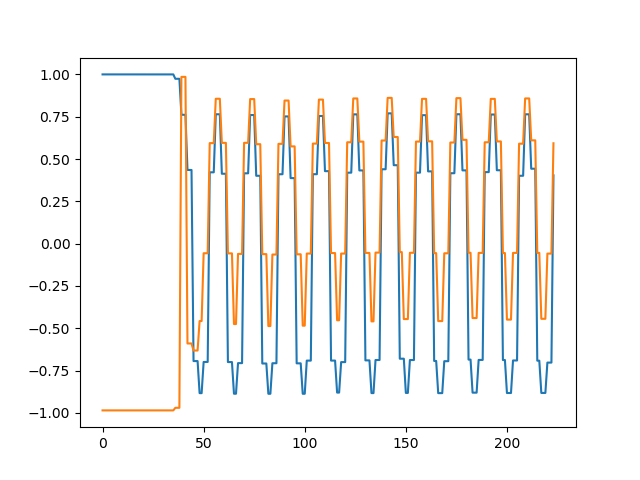

In [2045]:
close("all")
plot(p0s)
plot(p1s)

In [42]:
r.close()